In [42]:
#Setup - import packages
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers,optimizers,losses,callbacks
import numpy as np 
import matplotlib.pyplot as plt 
import os,datetime

In [43]:
#Data loading
data_dir = r'D:\SHRDC\Cracks or No Cracks\Cracks Classification\data'
data = tf.keras.utils.image_dataset_from_directory(data_dir,
                                                            shuffle=True,
                                                            batch_size=32,
                                                            image_size=(227,227))

Found 40000 files belonging to 2 classes.


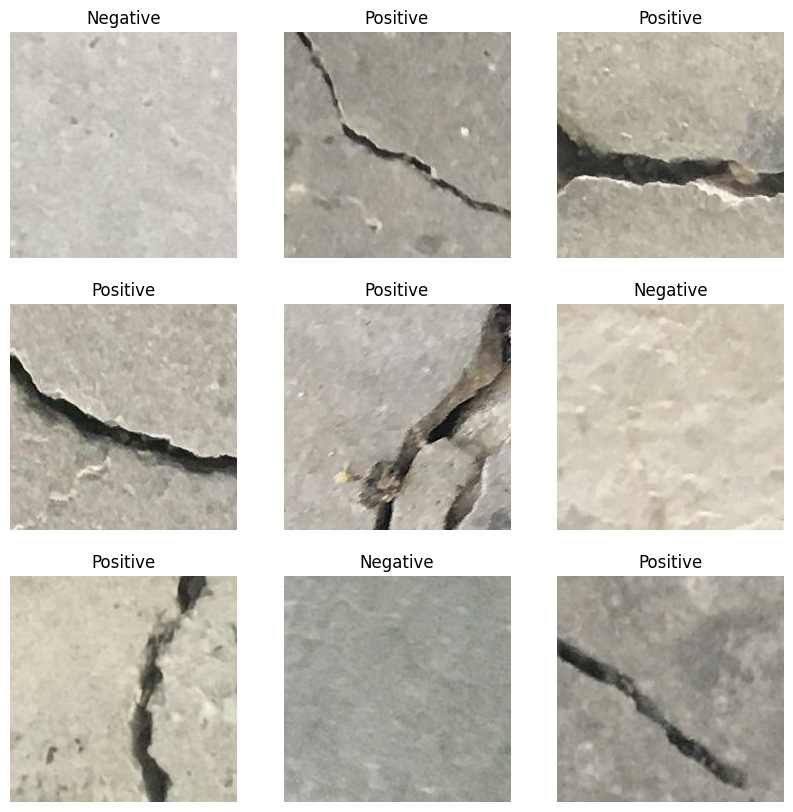

In [44]:
#Inspect some data examples
class_names = data.class_names

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [45]:
# Calculate the number of batches in the full data
num_batches = tf.data.experimental.cardinality(data)
print(num_batches)

tf.Tensor(1250, shape=(), dtype=int64)


In [46]:
# Split the dataset into training, validation, and test sets
train_dataset = data.take(num_batches * 3 // 5)  # 60% for training
remaining_dataset = data.skip(num_batches * 3 // 5)

val_batches = num_batches // 10  # 10% for validation
val_dataset = remaining_dataset.take(val_batches)

test_dataset = remaining_dataset.skip(val_batches)  # 30% for testing

In [47]:
#Convert into tensorflow
AUTOTUNE = tf.data.AUTOTUNE

# Prefetching for training dataset
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

# Prefetching for validation dataset
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

# Prefetching for test dataset
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [48]:
#Create a sequential model for image augmentation
data_augmentation = keras.Sequential()
data_augmentation.add(layers.RandomFlip('horizontal'))
data_augmentation.add(layers.RandomRotation(0.2))

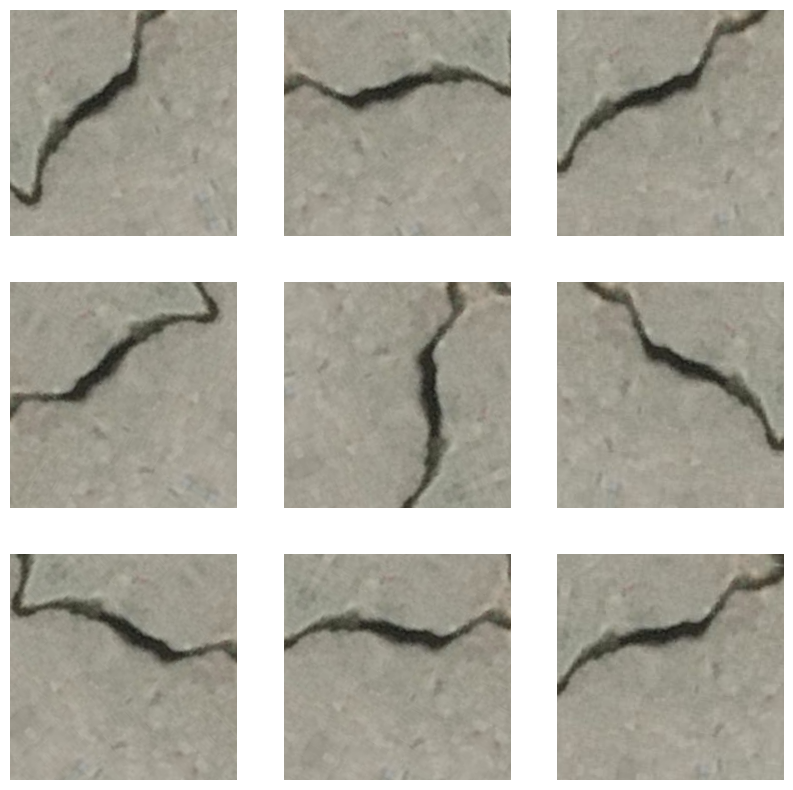

In [52]:
#Visualizing data augmentation
for image, _ in data.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [53]:
#Data normalization - define a layer for it 
from tensorflow.keras import applications
preprocess_input = applications.mobilenet_v2.preprocess_input

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 227, 227, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 114, 114, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 114, 114, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 114, 114, 32)         0         ['bn_Conv1[

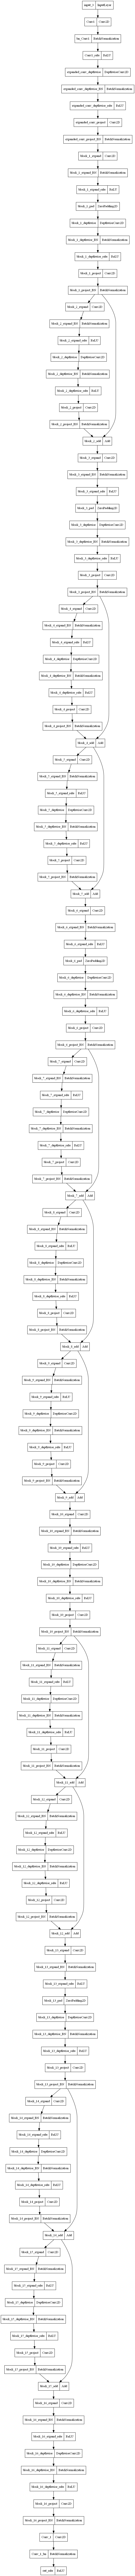

In [54]:
#Construct the transfer learning pipeline
#Pipeline: data augmentation > preprocess input > transfer learning model
#(A) Load the pretrained model using keras.applications 
IMG_SIZE = (227,227)
IMG_SHAPE = IMG_SIZE + (3,)
base_model = applications.MobileNetV2(input_shape=IMG_SHAPE,include_top=False,weights='imagenet')
base_model.summary()
keras.utils.plot_model(base_model)

In [55]:
#(B) Freeze the entire feature extractor 
base_model.trainable = False 
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 227, 227, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 114, 114, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 114, 114, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 114, 114, 32)         0         ['bn_Conv1[

In [56]:
#(C) Create global average pooling layer
global_avg = layers.GlobalAveragePooling2D()
#(D) Create the output layer with Dense Layer 
output_layer = layers.Dense(len(class_names), activation='softmax')
#(E) Build the entire pipeline using functional API 
#a. Input
inputs = keras.Input(shape=IMG_SHAPE)
#b. Data augmentation 
x = data_augmentation(inputs)
#c. Data normalization 
x = preprocess_input(x)
#d. Transfer learning feature extractor 
x = base_model(x,training = False)
#e. Classification layers
x = global_avg(x)
x = layers.Dropout(0.3)(x)
outputs = output_layer(x)
#f. Build the model 
model = keras.Model(inputs = inputs,outputs = outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 227, 227, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLam  (None, 227, 227, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_1 (TFOpLa  (None, 227, 227, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                           

In [58]:
#Compile the model 
optimizer = optimizers.Adam(learning_rate= 0.0001)
loss = losses.SparseCategoricalCrossentropy()
model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

In [59]:
#Prepare the callback objects for model.fit()
early_stopping = callbacks.EarlyStopping(patience=2)
PATH = os.getcwd()
logpath = os.path.join(PATH, "tensorboard_log",datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = callbacks.TensorBoard(logpath)

In [60]:
#Evaluate the model with test data before training
model.evaluate(test_dataset)

375/375 [==============================] - 240s 587ms/step - loss: 0.7059 - accuracy: 0.5742


[0.705880343914032, 0.5741666555404663]

In [61]:
EPOCHS = 10
history = model.fit(train_dataset,validation_data=val_dataset,epochs=EPOCHS,callbacks=[early_stopping,tb])

Epoch 1/10
750/750 [==============================] - 581s 770ms/step - loss: 0.1229 - accuracy: 0.9640 - val_loss: 0.0271 - val_accuracy: 0.9942
Epoch 2/10
750/750 [==============================] - 565s 753ms/step - loss: 0.0265 - accuracy: 0.9940 - val_loss: 0.0165 - val_accuracy: 0.9962
Epoch 3/10
750/750 [==============================] - 567s 756ms/step - loss: 0.0172 - accuracy: 0.9955 - val_loss: 0.0139 - val_accuracy: 0.9960
Epoch 4/10
750/750 [==============================] - 567s 755ms/step - loss: 0.0145 - accuracy: 0.9959 - val_loss: 0.0112 - val_accuracy: 0.9970
Epoch 5/10
750/750 [==============================] - 570s 760ms/step - loss: 0.0107 - accuracy: 0.9966 - val_loss: 0.0118 - val_accuracy: 0.9973
Epoch 6/10
750/750 [==============================] - 571s 761ms/step - loss: 0.0094 - accuracy: 0.9973 - val_loss: 0.0118 - val_accuracy: 0.9965


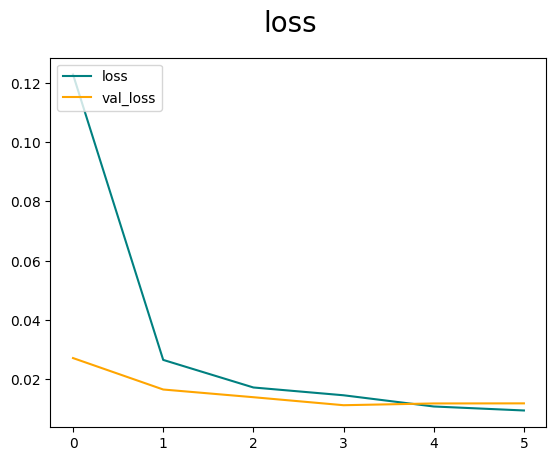

In [62]:
fig = plt.figure()
plt.plot(history.history['loss'], color = 'teal', label = 'loss')
plt.plot(history.history['val_loss'], color = 'orange', label= 'val_loss')
fig.suptitle('loss', fontsize = 20)
plt.legend(loc='upper left')
plt.show()

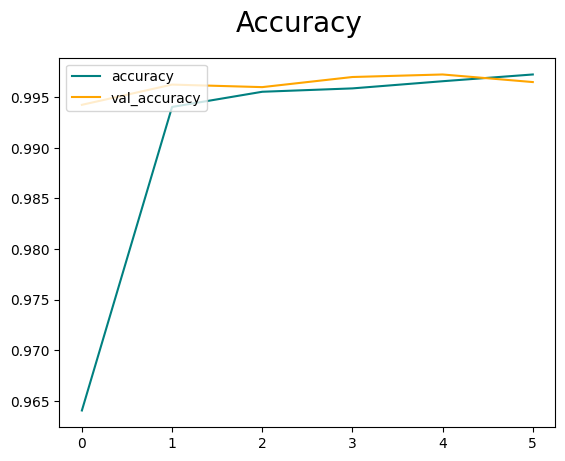

In [63]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color = 'teal', label = 'accuracy')
plt.plot(history.history['val_accuracy'], color = 'orange', label= 'val_accuracy')
fig.suptitle('Accuracy', fontsize = 20)
plt.legend(loc='upper left')
plt.show()

In [64]:
os.getcwd()

'd:\\SHRDC\\Cracks or No Cracks\\Cracks Classification'

In [65]:
#Evaluate the model after training 
model.evaluate(test_dataset)

375/375 [==============================] - 236s 588ms/step - loss: 0.0086 - accuracy: 0.9973


[0.008641321212053299, 0.9973333477973938]

In [66]:
#(A) Retrive a batch of data from test data and perform prediction 
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

In [67]:
#(B) Identify the class for the predictions
prediction_indexes = np.argmax(predictions,axis=1)

In [68]:
prediction_indexes

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 1, 0], dtype=int64)

In [69]:
#(C) Display the result using matplotlib
label_map = {i:names for i,names in enumerate(class_names)}
prediction_list = [label_map[i] for i in prediction_indexes]
label_list = [label_map[i] for i in label_batch]

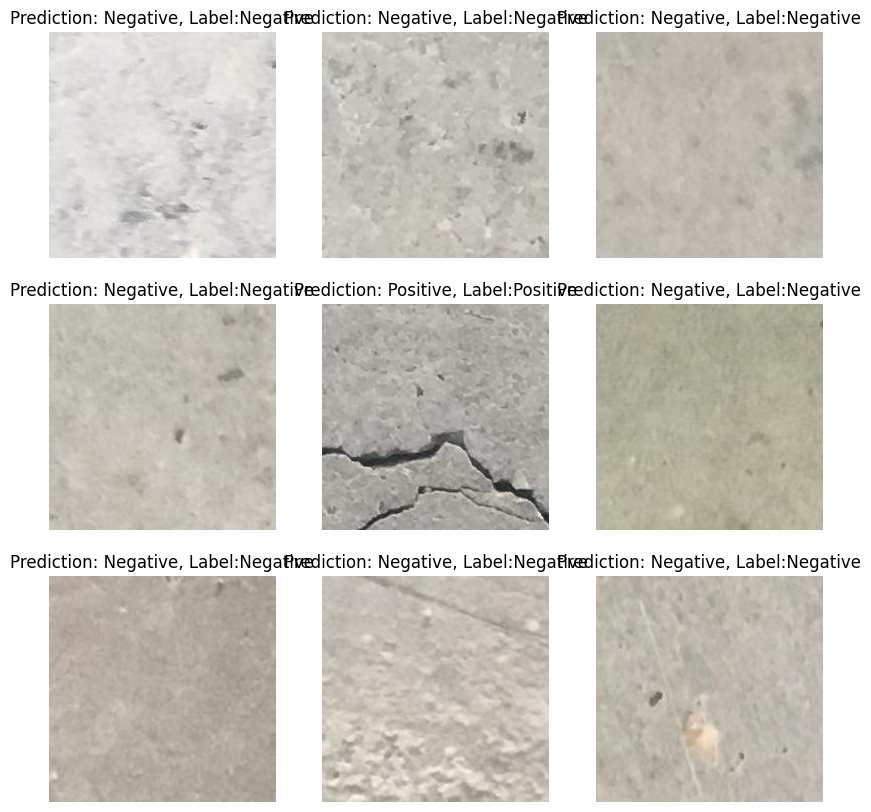

In [70]:
#(D) Plot the image graph using matplotlib 
plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(image_batch[i].astype('uint8'))
    plt.title(f'Prediction: {prediction_list[i]}, Label:{label_list[i]}')
    plt.axis('off')
    plt.grid('off')

Save the Model

In [71]:
from tensorflow.keras.models import load_model
model.save(os.path.join('models','crack_classify_v2.h5'))

d:\anacondapython\envs\AI07_GPU\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
